In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
import pickle
plt.rcParams['figure.dpi']= 200

import torch
from torch import optim, nn
from torch.autograd import Variable

In [2]:
task_stim=pd.read_excel('contstim_pilot_n11_spreadsheet.xlsx')
task_data=pd.read_csv('data_exp_22452-v9_task-ax2v.csv')

In [50]:
models=['bigram','trigram','rnn','lstm','bilstm','bert','bert_whole_word','roberta','xlm','electra','gpt2']

prob_dict=dict()
for model_name in models:
    f = open(model_name+'_expt1_sentence_probs.pkl','rb')
    dict1=pickle.load(f)
    prob_dict[model_name]=dict1
    
    
events=list(task_data['Event Index'])
start_inds=[i for i,e in enumerate(events) if e=='1']

fitsets=[]

all_sents=[]

item_responses=dict()

for i,start_ind in enumerate(start_inds):

    setnum=task_data['counterbalance-o1ql'][start_ind]

    if i==12:
        setnum='set 12'

    sub=task_data['Participant External Session ID'][start_ind]

    model1_list=list(task_stim['sentence1_model_'+setnum])[1:]
    model2_list=list(task_stim['sentence2_model_'+setnum])[1:]
    sent1_list=list(task_stim['sentence1_'+setnum])[1:]
    sent2_list=list(task_stim['sentence2_'+setnum])[1:]

    if setnum=='set 1':
        source_list=list(task_stim['source'])[1:]

    else:
        source_list=list(task_stim['source_'+setnum])[1:]

    if i<len(start_inds)-1:
        responses_list=list(task_data['Response'][start_ind:start_inds[i+1]])

    else:
        responses_list=list(task_data['Response'][start_ind:])

    responses_list=[r for r in responses_list if str(r)!='nan']

    item_ids=[]

    fitset=[]
    
    for t in range(110):

        source=source_list[t]

        model1=model1_list[t]
        model2=model2_list[t]
        sent1=sent1_list[t]
        sent2=sent2_list[t]
        
        all_sents.append(sent1)
        all_sents.append(sent2)

        model1_name=model1[:-2]
        model2_name=model2[:-2]        

        model_ind=models.index(model1_name)

        sents=[sent1,sent2]
        sents.sort()
        item_id='_'.join(sents)
        
        response=responses_list[t]
        
        if item_id in item_ids:
            continue
            
        if item_id not in item_responses:
            item_responses[item_id]=[sents.index(response)]
        else:
            item_responses[item_id].append(sents.index(response))
        
        item_ids.append(item_id)


        response_ind=[sent1,sent2].index(response)     
        
        for model_name in models:#[model1_name]

            log_p1=prob_dict[model_name][sent1]
            log_p2=prob_dict[model_name][sent2]

            fitset.append([model_name,log_p1,log_p2,response_ind])
        
    fitsets.append(fitset)

fitsets_all=[]
for fitset in fitsets:
    fitsets_all+=fitset


In [51]:
human_choice_probs=[]
for item in item_responses:
    resp_list=item_responses[item]
    
    human_choice_prob=-1*np.log(np.max([np.sum(resp_list)/len(resp_list),1-np.sum(resp_list)/len(resp_list)]))
    
    human_choice_probs.append(human_choice_prob)
    
    
np.mean(human_choice_probs)



0.2828633252812555

In [52]:
minps=[]
for m in models:
    m=np.min([np.min([trial[1],trial[2]]) for trial in fitsets_all if trial[0]==m])
    minps.append(m)
    
minps=np.abs(minps)


maxps=[]
for m in models:
    m=np.max([np.max([trial[1],trial[2]]) for trial in fitsets_all if trial[0]==m])
    maxps.append(m)
    
maxps=np.abs(maxps)



To avoid overflow within exponentials when calculating probabilities, we'll use torch.logsumexp where log(exp(x)+1) is required.

In [53]:
# this is mathemathically eqivalent to torch.log(1+torch.exp(x)) but it doesn't overflow when x is big.
log_1_plus_exp_x=lambda x: torch.logsumexp(torch.stack((x,torch.zeros_like(x)),dim=-1),dim=1)

# this is mathemathically equivalent to log(1/(1+exp(x)))
log_p=lambda x: -log_1_plus_exp_x(x) 

# this is mathemathically equivalent to log(1 - 1/(1+exp(x)) )
log_1_minus_p=lambda x: x+log_p(x)

x=torch.tensor([-100.0,50.0,-1.0,0.0,1.0,50.0,100.0])
print('log(1+exp(x)) | direct implementation:', torch.log(1+torch.exp(x)))
print('log(1+exp(x)) | with logsumexp:', log_1_plus_exp_x(x))

print('log(1/(1+exp(x))) | direct implementation:', torch.log(1/(1+torch.exp(x))))
print('log(1/(1+exp(x))) | with logsumexp:', log_p(x))

print('log(1 - 1/(1+exp(x))) | direct implementation:', torch.log(1-1/(1+torch.exp(x))))
print('log(1 - 1/(1+exp(x))) | with logsumexp:', log_1_minus_p(x))

log(1+exp(x)) | direct implementation: tensor([ 0.0000, 50.0000,  0.3133,  0.6931,  1.3133, 50.0000,     inf])
log(1+exp(x)) | with logsumexp: tensor([  0.0000,  50.0000,   0.3133,   0.6931,   1.3133,  50.0000, 100.0000])
log(1/(1+exp(x))) | direct implementation: tensor([  0.0000, -50.0000,  -0.3133,  -0.6931,  -1.3133, -50.0000,     -inf])
log(1/(1+exp(x))) | with logsumexp: tensor([  -0.0000,  -50.0000,   -0.3133,   -0.6931,   -1.3133,  -50.0000,
        -100.0000])
log(1 - 1/(1+exp(x))) | direct implementation: tensor([   -inf,  0.0000, -1.3133, -0.6931, -0.3133,  0.0000,  0.0000])
log(1 - 1/(1+exp(x))) | with logsumexp: tensor([-100.0000,    0.0000,   -1.3133,   -0.6931,   -0.3133,    0.0000,
           0.0000])


In [89]:

class ModelToHumanDecision():
    def _set_initial_parameters(self):
        raise NotImplementedError
        
    def __init__(self,model_name_list,parameters=None,device=None):
        if device is None:
            device='cpu'
        
        self.device=torch.device(device)
        self.model_name_list=model_name_list
        self.n_models=len(model_name_list)
        
        if parameters is None:
            self.parameters=self._initial_parameters()
        else:
            self.parameters={key:torch.tensor(value,device=self.device,dtype=torch.float64) for (key,value) in parameters.items()}

    def _f(self,log_p1,log_p2,cur_parameters):
        raise NotImplementedError
        
    def decision_NLL(self,log_p1,log_p2,model=None):
        
        log_p1=torch.as_tensor(log_p1,device=self.device,dtype=torch.float64)
        log_p2=torch.as_tensor(log_p2,device=self.device,dtype=torch.float64)
        
        if model is None: # evaluate all models. # log_p1, log_p2 (n_models,n_sentence_pairs)
            assert log_p1.ndim==2 and log_p1.shape[0]==self.n_models and log_p2.ndim==3 and log_p2.shape[0]==self.n_models 
            slicer=...
        elif type(model) is str: # one particular model specified by its name
            slicer=self.model_name_list.index(model)
        elif type(model) is int: # one particular model specified by its index
            slicer=model
        elif type(model) is list: # a list of model names
            slicer=torch.tensor([self.model_name_list.index(m) for m in model])
        else:
            raise 
        cur_parameters={}
        
#         print(self.parameters.items())
#         sys.e
        
        for par_name, par in self.parameters.items():
            if par.nelement()==1:
                cur_parameters[par_name]=par
            else:
                cur_parameters[par_name]=par[slicer]
        return self._f(log_p1,log_p2,cur_parameters)
    
    def get_parameters(self):
        numpy_parameters={}
        for par_name, par in self.parameters.items():
            if par.nelement()==1:
                numpy_parameters[par_name]=par.item()
            else:
                numpy_parameters[par_name]=par.detach().cpu().numpy()
        return numpy_parameters

class FixedWidthSquashing(ModelToHumanDecision):
    def _initial_parameters(self):
        parameters={}
        parameters['squashes']=torch.ones(self.n_models,device=self.device)*200.0 # this doesn't work
        parameters['gamma']=torch.tensor(10.0,device=self.device)
        return parameters
    def _f(self,log_p1,log_p2,cur_parameters):
        gamma=cur_parameters['gamma']
        squash_threshold=cur_parameters['squashes']     
        width=1.0
        log_p1_corrected=width*log_1_plus_exp_x((log_p1+squash_threshold)/width)-squash_threshold
        log_p2_corrected=width*log_1_plus_exp_x((log_p2+squash_threshold)/width)-squash_threshold
        s1a_b = log_p1_corrected - log_p2_corrected
#         p1=1/(1+torch.exp(-(s1a_b)/gamma))
#         p2=1-p1
#         choice_NLL=-torch.log(torch.stack([p1,p2],dim=-1))        
        log_p1=log_p(-s1a_b/gamma)
        log_p2=log_1_minus_p(-s1a_b/gamma)
        choice_NLL=-torch.stack([log_p1,log_p2],dim=-1)
        return choice_NLL

    
class FixedWidthSquashingVariableGamma(ModelToHumanDecision):
    def _initial_parameters(self):
        parameters={}
        parameters['squashes']=torch.ones(self.n_models,device=self.device)*200.0 # this doesn't work
        parameters['gamma']=torch.ones(self.n_models,device=self.device)*10.0
        return parameters
    
    def _f(self,log_p1,log_p2,cur_parameters):
        gamma=cur_parameters['gamma']
        squash_threshold=cur_parameters['squashes']     
        width=1.0
        log_p1_corrected=width*log_1_plus_exp_x((log_p1+squash_threshold)/width)-squash_threshold
        log_p2_corrected=width*log_1_plus_exp_x((log_p2+squash_threshold)/width)-squash_threshold
        #log_p1_corrected=width*torch.log(1+math.e**((log_p1+squash_threshold)/width))-squash_threshold
        #log_p2_corrected=width*torch.log(1+math.e**((log_p2+squash_threshold)/width))-squash_threshold
        s1a_b = log_p1_corrected - log_p2_corrected
#         p1=1/(1+torch.exp(-(s1a_b)/gamma))
#         p2=1-p1
#         choice_NLL=-torch.log(torch.stack([p1,p2],dim=-1))
        log_p1=log_p(-s1a_b/gamma)
        log_p2=log_1_minus_p(-s1a_b/gamma)
        choice_NLL=-torch.stack([log_p1,log_p2],dim=-1)
        return choice_NLL

class VariableWidthSquashing(ModelToHumanDecision):
    def _initial_parameters(self):
        parameters={}
        parameters['squashes']=torch.ones(self.n_models,device=self.device)*200.0 # this doesn't work
        parameters['gamma']=torch.tensor(10.0,device=self.device)
        parameters['width']=torch.ones(self.n_models,device=self.device)        
        return parameters
    
    def _f(self,log_p1,log_p2,cur_parameters):
        gamma=cur_parameters['gamma']
        squash_threshold=cur_parameters['squashes']     
        width=torch.nn.Softplus()(cur_parameters['width'])+1e-1
        log_p1_corrected=width*log_1_plus_exp_x((log_p1+squash_threshold)/width)-squash_threshold
        log_p2_corrected=width*log_1_plus_exp_x((log_p2+squash_threshold)/width)-squash_threshold
#         log_p1_corrected=width*torch.log(1+torch.exp((log_p1+squash_threshold)/width))-squash_threshold
#         log_p2_corrected=width*torch.log(1+torch.exp((log_p2+squash_threshold)/width))-squash_threshold
        s1a_b = log_p1_corrected - log_p2_corrected
        log_p1=log_p(-s1a_b/gamma)
        log_p2=log_1_minus_p(-s1a_b/gamma)
        choice_NLL=-torch.stack([log_p1,log_p2],dim=-1)
#         p1=1/(1+torch.exp(-(s1a_b)/gamma))
#         p2=1-p1
#         choice_NLL=-torch.log(torch.stack([p1,p2],dim=-1))
        return choice_NLL


class VariableWidthSquashingVariableGamma(ModelToHumanDecision):
    def _initial_parameters(self):
        parameters={}
        parameters['squashes']=torch.ones(self.n_models,device=self.device)*200.0 # this doesn't work
        parameters['gamma']=torch.ones(self.n_models,device=self.device)*10.0
        parameters['width']=torch.ones(self.n_models,device=self.device)

        return parameters
    def _f(self,log_p1,log_p2,cur_parameters):
        gamma=cur_parameters['gamma']
        squash_threshold=cur_parameters['squashes']     
        width=torch.nn.Softplus()(cur_parameters['width'])+1e-1
        log_p1_corrected=width*log_1_plus_exp_x((log_p1+squash_threshold)/width)-squash_threshold
        log_p2_corrected=width*log_1_plus_exp_x((log_p2+squash_threshold)/width)-squash_threshold
#         log_p1_corrected=width*torch.log(1+math.e**((log_p1+squash_threshold)/width))-squash_threshold
#         log_p2_corrected=width*torch.log(1+math.e**((log_p2+squash_threshold)/width))-squash_threshold
        s1a_b = log_p1_corrected - log_p2_corrected
        log_p1=log_p(-s1a_b/gamma)
        log_p2=log_1_minus_p(-s1a_b/gamma)
        choice_NLL=-torch.stack([log_p1,log_p2],dim=-1)
#         p1=1/(1+torch.exp(-(s1a_b)/gamma))
#         p2=1-p1
#         choice_NLL=-torch.log(torch.stack([p1,p2],dim=-1))
        return choice_NLL
    

class VariableGammaNoSquash(ModelToHumanDecision):
    def _initial_parameters(self):
        parameters={}
        parameters['gamma']=torch.ones(self.n_models,device=self.device)*10.0
        return parameters
    def _f(self,log_p1,log_p2,cur_parameters):
        gamma=cur_parameters['gamma']
        s1a_b = log_p1 - log_p2
        p1=1/(1+torch.exp(-(s1a_b)/gamma))
        p2=1-p1
        choice_NLL=-torch.log(torch.stack([p1,p2],dim=-1))
        return choice_NLL
    
class SquashedSoftmax(ModelToHumanDecision):
    def _initial_parameters(self):
        parameters={}
        parameters['gamma']=torch.ones(self.n_models,device=self.device)*10.0
        parameters['eta']=torch.ones(self.n_models,device=self.device)*(0.0)
        return parameters
    def _f(self,log_p1,log_p2,cur_parameters):
        gamma=cur_parameters['gamma']
        eta=cur_parameters['eta']
        
        denominator=torch.logsumexp(torch.stack([log_p1/gamma,torch.ones_like(log_p1)*eta,log_p2/gamma,torch.ones_like(log_p2)*eta],dim=-1),dim=-1)
        log_p1 = torch.logsumexp(torch.stack([log_p1/gamma,torch.ones_like(log_p1)*eta],dim=-1),dim=-1)-denominator
        log_p2 = torch.logsumexp(torch.stack([log_p2/gamma,torch.ones_like(log_p2)*eta],dim=-1),dim=-1)-denominator
        choice_NLL=-torch.stack([log_p1,log_p2],dim=-1)
        return choice_NLL    

In [91]:

from collections import defaultdict



# parameters={'squashes':minps,'gamma':10.0}
# model_class=FixedWidthSquashing

# parameters={'squashes':minps,'gamma':10.0,'width':np.ones(len(models))}
# model_class=VariableWidthSquashing

parameters={'squashes':minps,'gamma':np.ones_like(minps)*10.0}
model_class=FixedWidthSquashingVariableGamma

# parameters={'gamma':np.ones_like(minps)*10.0}
# model_class=VariableGammaNoSquash

# parameters={'squashes':minps,'gamma':np.ones_like(minps)*10.0,'width':np.ones(len(models))}
# model_class=VariableWidthSquashingVariableGamma

# parameters=None # use defaults
# model_class=SquashedSoftmax

device='cpu'

for boot in range(1):
    
    boots=np.random.choice(13, 13)
    boots=np.arange(13)
    
    fitset=[]
    for b in boots:
        fitset+=fitsets[b]
    
    decision_model=model_class(model_name_list=models,parameters=parameters,device=device)

    for par in decision_model.parameters.values():
        par.requires_grad=True
        
    opt = optim.Adam(decision_model.parameters.values(),lr=1)

    print(boot)
    print('')

    # build models by trials by sentences log-prob matrix
    
    log_p1=defaultdict(list)
    log_p2=defaultdict(list)
    response_ind=defaultdict(list)
    
    for trial in fitset:
        model1_name=trial[0]
        log_p1[model1_name].append(trial[1])
        log_p2[model1_name].append(trial[2])
        response_ind[model1_name].append(trial[3])
    
    for epoch in range(1000): # for some models, one needs more than 200 epochs for convergence. I'd replace this loop with a convergence criterion.

        loss = torch.tensor(0.,device=device,requires_grad = True)
        
        model_loss=torch.zeros((len(models)),device=device)
        for i_model,model1_name in enumerate(models):
            log_p_sent=decision_model.decision_NLL(log_p1[model1_name],log_p2[model1_name],model=model1_name)
            take_by_2nd_dim=lambda x, idx: x[torch.arange(x.size(0)), idx] 
            log_p_choice=take_by_2nd_dim(log_p_sent,response_ind[model1_name])
            model_loss[i_model]=log_p_choice.mean()
            loss=loss+model_loss[i_model]
            
        if epoch%90==0:
            print('loss:',loss)
            for par_name, par in decision_model.parameters.items():
                print(par_name,par)
            print('')

        loss.backward()
        opt.step()
        opt.zero_grad()
    
    print(decision_model.get_parameters())
    print('total loss:',loss)
    for i_model,model1_name in enumerate(models):
        print('{} {:.2f}'.format(model1_name,model_loss[i_model].item()))
    
    squashes=list(decision_model.parameters['squashes'].data.numpy())
    gammas=list(decision_model.parameters['gamma'].data.numpy())
    #gammas=float(decision_model.parameters['gamma'])
    
    if boot==0:
        squash_boots=[squashes]
        gamma_boots=[gammas]
        losses=[[model_loss[i_model].item() for i_model in range(11)]]
    else:
        squash_boots.append(squashes)
        gamma_boots.append(gammas)
        losses.append([model_loss[i_model].item() for i_model in range(11)])


0

loss: tensor(10.3490, grad_fn=<AddBackward0>)
gamma tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.],
       dtype=torch.float64, requires_grad=True)

loss: tensor(6.8869, grad_fn=<AddBackward0>)
gamma tensor([31.8335, 32.6852, 39.3416, 39.5400, 35.9329, 35.4862, 36.7485, 35.5184,
        36.1569, 35.2928, 34.8076], dtype=torch.float64, requires_grad=True)

loss: tensor(6.8663, grad_fn=<AddBackward0>)
gamma tensor([32.6920, 33.9598, 45.8873, 46.1914, 39.5871, 38.8304, 41.0978, 38.8254,
        40.0285, 38.4412, 37.5812], dtype=torch.float64, requires_grad=True)

loss: tensor(6.8623, grad_fn=<AddBackward0>)
gamma tensor([32.7854, 34.1572, 49.6339, 49.9986, 41.0306, 40.0722, 43.0557, 40.0335,
        41.6347, 39.5458, 38.4566], dtype=torch.float64, requires_grad=True)

loss: tensor(6.8612, grad_fn=<AddBackward0>)
gamma tensor([32.7889, 34.1718, 51.9144, 52.3170, 41.5447, 40.4738, 43.9049, 40.4147,
        42.2508, 39.8731, 38.6758], dtype=torch.float64, requires_grad=Tru

KeyError: 'squashes'

In [ ]:
gT=np.array(gamma_boots).T
sT=np.array(squash_boots).T

ccs=[]
for i in range(11):
    
    cc=np.corrcoef(sT[i,:],gT[i,:])[0,1]
    ccs.append(cc)
    
ccs




-6.907755278982137

In [ ]:
#synthetic

# tensor(671.4779, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
# tensor([129.5626, 128.7844,  84.1193,  92.4041, 111.8108, 105.3416,  83.8154,
#         116.5818,  87.0363,  60.6492,  81.0560], device='cuda:0',
#        dtype=torch.float64, requires_grad=True)
# tensor([29.8585, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
#         10.0000, 10.0000, 10.0000], device='cuda:0', requires_grad=True)


#natural

# tensor(148.7837, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
# tensor([115.8415,  84.2844,  72.0876,  43.8699,  54.9998,  50.4821,  69.6983,
#          49.1065,  42.4528,  34.6840,  59.5816], device='cuda:0',
#        dtype=torch.float64, requires_grad=True)
# tensor([ 9.1418, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
#         10.0000, 10.0000, 10.0000], device='cuda:0', requires_grad=True)


# tensor(829.6835, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
# tensor([129.1968, 127.7177,  83.4297,  91.0015, 111.4391, 104.3089,  83.3092,
#         115.3282,  85.6379,  59.8025,  79.7266], device='cuda:0',
#        dtype=torch.float64, requires_grad=True)
# tensor([28.2664, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
#         10.0000, 10.0000, 10.0000], device='cuda:0', requires_grad=True)


In [52]:
# squash_boots=np.array([[136.6031, 130.6315,  88.2857, 127.1014, 124.6718, 110.4878,  84.6417,
#         118.1435, 107.7737,  63.0790,  79.9143],
#               [137.9003, 125.7105,  84.5635, 127.1772, 112.0871,  94.5774,  78.6344,
#         114.0863,  95.4273,  58.2541,  79.6323],
#               [131.8761, 133.7181, 147.7142, 143.2530, 110.6293, 134.2203,  83.7578,
#         139.0220,  82.7407,  66.7261,  79.2919],
#               [139.6443, 135.6945,  80.5810,  94.8058, 116.6113, 103.0531,  87.4392,
#         119.7775,  81.2322,  60.9193,  81.1773],
#               [132.4967, 128.7608,  92.4549,  91.8489, 110.4346, 104.1544,  80.5317,
#         126.0785, 124.9601,  57.4880,  76.9285],
#               [128.2988, 112.9426,  80.0811,  90.9844, 111.0652, 115.8396,  56.3730,
#          78.9889, 120.2621,  29.6331,  61.9582],
#               [127.7181, 132.9688, 148.8201,  94.7272, 109.7225,  87.5404,  81.3132,
#         115.8013, 116.9241,  64.7583,  73.5550],
#               [120.8540, 116.8421, 135.4461,  88.5892, 124.1079, 133.7935,  86.1704,
#         100.1683,  92.7386,  49.7565,  79.4477],
#               [125.4391, 114.5180,  82.5459,  87.4416, 110.8198,  93.8739,  63.4568,
#         117.9814,  83.9064,  57.2624,  77.2107],
#               [129.6447, 129.3590,  86.6444,  92.5276, 109.5141, 105.0256,  65.8152,
#         117.5682, 125.8277,  59.4612,  77.8789]])

s=squash_boots

squash_boots=np.array(losses).T
squash_boots.sort()
squash_boots=squash_boots.T

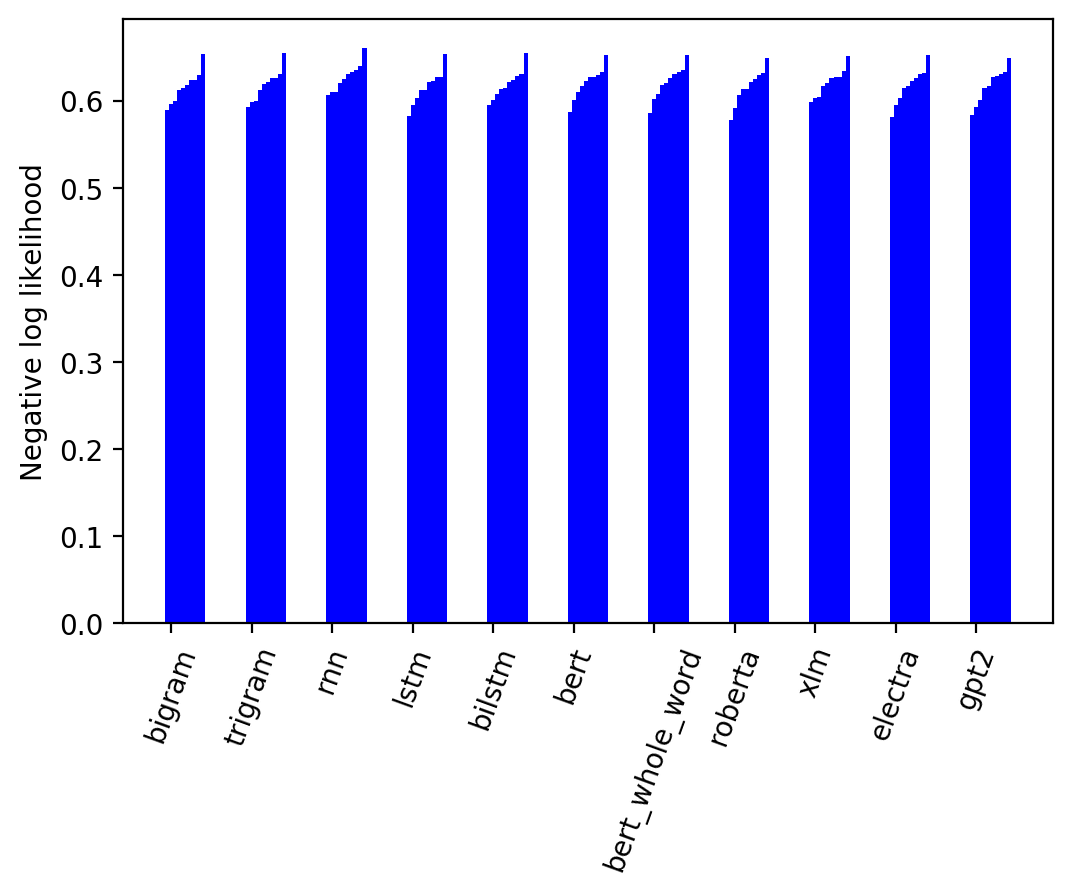

In [54]:
#squash_boots=squash_boots.reshape([10,11])



x=np.arange(11)*2
# plt.bar(x-0.2, maxps, width=0.1, color=[1,0,0])
plt.bar(x-0.1, squash_boots[0], width=0.1, color=[0,0,1])
plt.bar(x, squash_boots[1], width=0.1, color=[0,0,1])
plt.bar(x+0.1, squash_boots[2], width=0.1, color=[0,0,1])
plt.bar(x+0.2, squash_boots[3], width=0.1, color=[0,0,1])
plt.bar(x+0.3, squash_boots[4], width=0.1, color=[0,0,1])
plt.bar(x+0.4, squash_boots[5], width=0.1, color=[0,0,1])
plt.bar(x+0.5, squash_boots[6], width=0.1, color=[0,0,1])
plt.bar(x+0.6, squash_boots[7], width=0.1, color=[0,0,1])
plt.bar(x+0.7, squash_boots[8], width=0.1, color=[0,0,1])
plt.bar(x+0.8, squash_boots[9], width=0.1, color=[0,0,1])
# plt.bar(x+0.9, minps, width=0.1, color=[1,0,0])

# plt.ylabel('Squash Thresholds')
plt.ylabel('Negative log likelihood')
plt.xticks(x,models,rotation=70)

# plt.ylim([800,950])

legs=['Min/Max baseline','Squash thresholds']
# plt.legend(legs,bbox_to_anchor=(1, 0.3, 0.2, 0.5))

In [ ]:
squash_boots

In [33]:
sT

array([[140.29117373, 150.75698377, 145.80932154, 143.99388697,
        177.31373974, 153.27990117, 139.63242063, 150.57327311,
        150.54922929, 150.42798408],
       [129.24877692, 139.86180678, 135.5419875 , 131.18333257,
        163.37711984, 162.05709665, 128.51316508, 155.62589788,
        149.35908846, 139.9943368 ],
       [204.12534031, 204.14486678, 204.08978792, 204.23991628,
        196.73882873, 204.20927586, 196.63301314, 204.04086252,
        204.24834932, 204.03396348],
       [ 89.07134066,  95.91302419, 209.32015661, 209.81326758,
        207.01851519,  96.19709064,  91.00762092, 209.24503421,
        209.71241912,  96.3306568 ],
       [ 84.05881709,  90.55089208,  86.81947642,  87.22912904,
        121.37113893,  93.07116699,  83.51733044,  90.38951254,
         88.94565658,  88.46063076],
       [166.68818907,  94.3503403 ,  88.21564702,  98.35612372,
        139.76436302,  94.10901182, 140.01693247,  98.98451306,
        166.67745248,  89.46691221],
       [16

In [ ]:
d=squash_boots.T

In [ ]:

d=np.array([f.sort() for f in d])

In [ ]:
d

In [ ]:
squash_boots=d.T

In [ ]:
slist=list(set(all_sents))

In [ ]:
file=open('test_sents_expt1_first13subs.txt','w')
for s in slist:
    file.write(s)
    file.write('\n')

In [ ]:
len(slist)

In [ ]:
decision_model.parameters['squashes'].data.numpy()


In [36]:
np.log(0.9)

-0.10536051565782628

In [38]:
[sent1,sent2].sort()

In [84]:
g=0
a=0
for trial in fitset:
    
    if trial[0]=='electra':
        
        a+=1
    
        pa=trial[1]
        pb=trial[2]
        c=trial[3]

        if c==0 and pa>pb:
            g+=1
        elif c==1 and pb>pa:
            g+=1


In [85]:
g/a

0.6602941176470588

In [73]:
g

9878

In [74]:
g/len(fitset)

0.6602941176470588

In [75]:
np.log(.66)

-0.4155154439616658